In [0]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FINAL-TF2-FILES/TF_2_Notebooks_and_Data/DATA/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [0]:
df.columns = ['Sales']

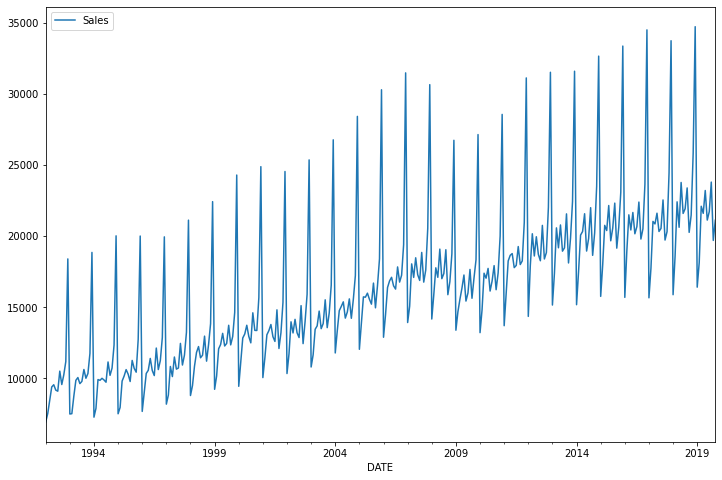

In [6]:
df.plot(figsize=(12,8))

In [7]:
len(df)

334

In [8]:
len(df)- 18

316

In [0]:
test_size = 12

In [0]:
test_ind = len(df)- test_size

In [0]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [45]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381


In [46]:
test

,Sales
DATE,
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410
2019-02-01,18134
2019-03-01,22093
2019-04-01,21597
2019-05-01,23200
2019-06-01,21123
2019-07-01,21714


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [49]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [0]:
# What does the first batch look like?
X,y = generator[0]

In [54]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [0]:
# We're only using one feature in our time series
n_features = 1

In [0]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [0]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length-1, batch_size=1)

In [65]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
310/310 [==============================] - 2s 7ms/step - loss: 0.0017 - val_loss: 0.0522
Epoch 2/20
310/310 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 0.0367
Epoch 3/20
310/310 [==============================] - 2s 7ms/step - loss: 0.0014 - val_loss: 0.0337
Epoch 4/20
310/310 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 0.0398
Epoch 5/20
310/310 [==============================] - 2s 7ms/step - loss: 0.0015 - val_loss: 0.0469


In [0]:
losses = pd.DataFrame(model.history.history)

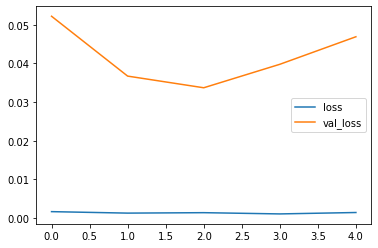

In [67]:
losses.plot()

In [0]:
n_input = 12

In [0]:
first_eval_batch = scaled_train[-length:]

In [0]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [71]:
model.predict(first_eval_batch)

array([[0.6661495]], dtype=float32)

In [72]:
scaled_test[0]

array([0.68592071])

In [0]:
import numpy as np
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [0]:
true_predictions = scaler.inverse_transform(test_predictions)

In [75]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
test

,Sales,Predictions
DATE,,
2018-11-01,25831,25286.421746
2018-12-01,34706,35866.369852
2019-01-01,16410,16602.362824
2019-02-01,18134,19478.230842
2019-03-01,22093,23153.059123
2019-04-01,21597,21401.909112
2019-05-01,23200,24573.911951
2019-06-01,21123,22307.515015
2019-07-01,21714,22682.517059


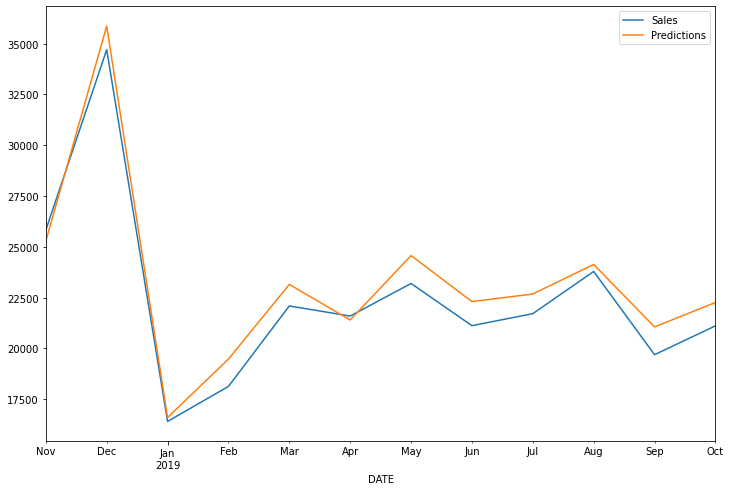

In [77]:
test.plot(figsize=(12,8))

In [0]:
from sklearn.metrics import mean_squared_error

In [83]:
np.sqrt(mean_squared_error(test["Sales"],test["Predictions"]))

1007.7714014339798

In [0]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [0]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [87]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0248
Epoch 2/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0163
Epoch 3/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0073
Epoch 4/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0026
Epoch 5/8
322/322 [==============================] - 2s 8ms/step - loss: 0.0018
Epoch 6/8
322/322 [==============================] - 2s 8ms/step - loss: 0.0018
Epoch 7/8
322/322 [==============================] - 2s 8ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0013


In [0]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [0]:
forecast = scaler.inverse_transform(forecast)

In [90]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [0]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [0]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [93]:
forecast_df

,Forecast
2019-11-01,23955.921006
2019-12-01,32738.887999
2020-01-01,16389.621532
2020-02-01,17765.597114
2020-03-01,20633.238321
2020-04-01,20248.480175
2020-05-01,21539.430329
2020-06-01,19879.083887
2020-07-01,20349.309093
2020-08-01,22043.487084


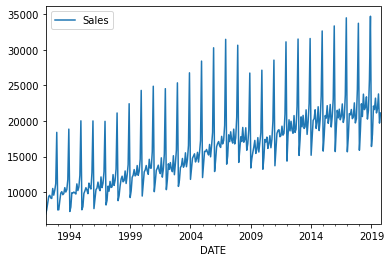

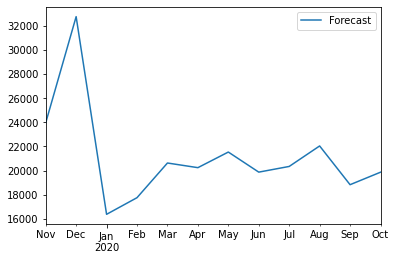

In [94]:
df.plot()
forecast_df.plot()

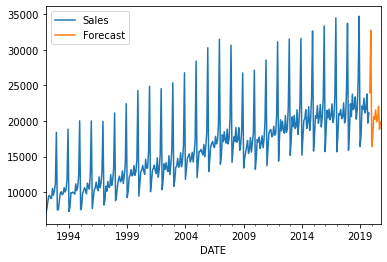

In [95]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

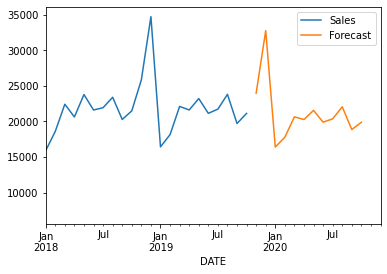

In [96]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')